In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_spec = np.load('/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_32/enc_train_32.npy')
stim_resp_all = np.load('/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_32/resp_train_32.npy')

In [4]:
ind = [165, 16, 191, 114, 12, 50, 96, 38, 211, 82, 130, 76, 142, 102, 107, 159, 156,
       66, 67, 206, 110, 93, 122, 125, 187, 68, 80, 81, 205, 147, 186, 63, 170, 51,
       2, 128, 41, 207, 35, 11, 21, 183, 112, 145, 53, 209, 57, 75, 31, 33]

In [5]:
stim_resp = stim_resp_all[:,ind,:]

In [6]:
np.shape(stim_spec), np.shape(stim_resp)

((54387, 32), (54387, 50, 64))

In [7]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=64, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [8]:
nsegbins = 64

In [9]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [10]:
np.shape(stim_mne), np.shape(resp_mne)

((54387, 32), (54387, 50))

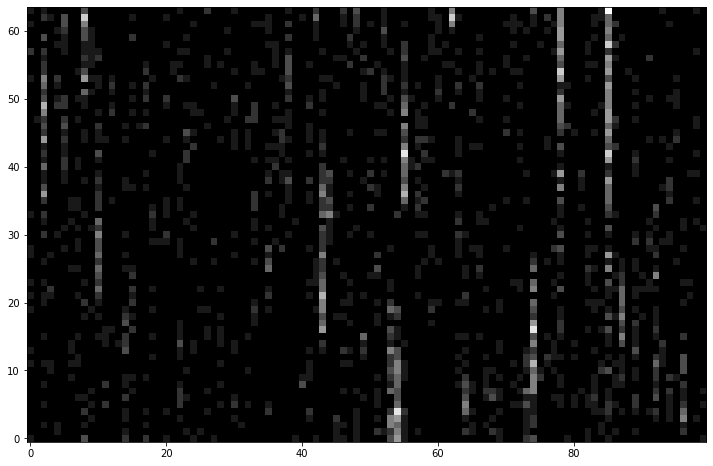

In [11]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [12]:
len_units = np.shape(resp_mne)[1]

In [13]:
units_to_process_all = np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy')
units_to_process = list(units_to_process_all[ind])

In [14]:
exp_path = '/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_32/'

In [15]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 32
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.147630
    2       0    0.147105
    3       0    0.145776
    4       0    0.145161
    5       0    0.144863
    6       0    0.144706
    7       0    0.144514
    8       0    0.144372
    9       0    0.144192
   10       0    0.144055
   11       0    0.144058
   12       1    0.143917
   13       0    0.143893
   14       0    0.143847
   15       0    0.143854
   16       1    0.143873
   17       2    0.143829
   18       0    0.143775
   19       0    0.143745
   20       0    0.143717
   21       0    0.143695
   22       0    0.143698
   23       1    0.143689
   24       0    0.143675
   25       0    0.143687
   26       1    0.143648
   27       0    0.143625
   28       0    0.143668
   29       1    0.143636
   30       2    0.143645
   31       3    0.143618
   32       0    0.143626
   33       1    0.143605
   34       0    0.143603
   35       0    0.143606
   36       1    0.143576
   37       0    0.143564
   38       

   79       6    0.158228
   80       7    0.158216
   81       0    0.158215
   82       0    0.158217
   83       1    0.158227
   84       2    0.158222
   85       3    0.158227
   86       4    0.158227
   87       5    0.158220
   88       6    0.158220
   89       7    0.158209
   90       0    0.158214
   91       1    0.158218
   92       2    0.158210
   93       3    0.158205
   94       0    0.158203
   95       0    0.158211
   96       1    0.158213
   97       2    0.158209
   98       3    0.158209
   99       4    0.158214
  100       5    0.158212
  101       6    0.158217
  102       7    0.158214
  103       8    0.158212
  104       9    0.158220
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.167828
    2       0    0.165852
    3       0    0.164507
    4       0    0.163396
    5       0    0.162779
    6       0    0.162548
    7       0    0.162029
    8       0    0.161806
    9       0    0.161399
   10       0    0.161154
   11       

    9       0    0.271517
   10       0    0.271029
   11       0    0.270924
   12       0    0.270723
   13       0    0.270691
   14       0    0.270667
   15       0    0.270514
   16       0    0.270381
   17       0    0.270282
   18       0    0.270243
   19       0    0.270224
   20       0    0.270111
   21       0    0.270069
   22       0    0.270071
   23       1    0.270037
   24       0    0.270052
   25       1    0.270022
   26       0    0.269977
   27       0    0.269982
   28       1    0.270002
   29       2    0.269989
   30       3    0.269974
   31       0    0.269917
   32       0    0.269896
   33       0    0.269898
   34       1    0.269907
   35       2    0.269930
   36       3    0.269909
   37       4    0.269888
   38       0    0.269876
   39       0    0.269824
   40       0    0.269815
   41       0    0.269803
   42       0    0.269787
   43       0    0.269782
   44       0    0.269768
   45       0    0.269761
   46       0    0.269776
   47       

   32       0    0.566555
   33       0    0.566541
   34       0    0.566422
   35       0    0.566369
   36       0    0.566302
   37       0    0.566258
   38       0    0.566216
   39       0    0.566201
   40       0    0.566205
   41       1    0.566178
   42       0    0.566162
   43       0    0.566166
   44       1    0.566145
   45       0    0.566112
   46       0    0.566121
   47       1    0.566124
   48       2    0.566115
   49       3    0.566096
   50       0    0.566105
   51       1    0.566094
   52       0    0.566093
   53       0    0.566089
   54       0    0.566088
   55       0    0.566087
   56       0    0.566075
   57       0    0.566073
   58       0    0.566063
   59       0    0.565987
   60       0    0.565957
   61       0    0.565945
   62       0    0.565936
   63       0    0.565945
   64       1    0.565930
   65       0    0.565923
   66       0    0.565932
   67       1    0.565934
   68       2    0.565923
   69       3    0.565918
   70       

  125       2    0.563755
  126       3    0.563752
  127       4    0.563751
  128       5    0.563752
  129       6    0.563755
  130       7    0.563759
  131       8    0.563755
  132       9    0.563749
  133       0    0.563748
  134       0    0.563753
  135       1    0.563737
  136       0    0.563726
  137       0    0.563727
  138       1    0.563729
  139       2    0.563729
  140       3    0.563724
  141       0    0.563721
  142       0    0.563725
  143       1    0.563726
  144       2    0.563721
  145       0    0.563721
  146       0    0.563722
  147       1    0.563721
  148       2    0.563721
  149       3    0.563720
  150       0    0.563715
  151       0    0.563714
  152       0    0.563712
  153       0    0.563713
  154       1    0.563714
  155       2    0.563713
  156       3    0.563714
  157       4    0.563717
  158       5    0.563716
  159       6    0.563714
  160       7    0.563715
  161       8    0.563717
  162       9    0.563717
minimum of t

Iters   tally   ll(test) 
    1       0    0.514855
    2       0    0.513294
    3       0    0.510475
    4       0    0.509775
    5       0    0.508983
    6       0    0.508799
    7       0    0.508426
    8       0    0.508219
    9       0    0.507915
   10       0    0.507806
   11       0    0.507678
   12       0    0.507572
   13       0    0.507427
   14       0    0.507287
   15       0    0.507152
   16       0    0.507076
   17       0    0.507000
   18       0    0.507002
   19       1    0.506867
   20       0    0.506786
   21       0    0.506755
   22       0    0.506724
   23       0    0.506694
   24       0    0.506607
   25       0    0.506556
   26       0    0.506530
   27       0    0.506539
   28       1    0.506563
   29       2    0.506453
   30       0    0.506302
   31       0    0.506272
   32       0    0.506267
   33       0    0.506260
   34       0    0.506230
   35       0    0.506197
   36       0    0.506176
   37       0    0.506167
   38       

  103       1    0.507624
  104       2    0.507626
  105       3    0.507623
  106       4    0.507620
  107       0    0.507621
  108       1    0.507615
  109       0    0.507610
  110       0    0.507610
  111       0    0.507602
  112       0    0.507600
  113       0    0.507598
  114       0    0.507594
  115       0    0.507598
  116       1    0.507598
  117       2    0.507595
  118       3    0.507593
  119       0    0.507593
  120       0    0.507591
  121       0    0.507595
  122       1    0.507596
  123       2    0.507587
  124       0    0.507585
  125       0    0.507586
  126       1    0.507582
  127       0    0.507584
  128       1    0.507582
  129       2    0.507576
  130       0    0.507575
  131       0    0.507572
  132       0    0.507569
  133       0    0.507574
  134       1    0.507571
  135       2    0.507573
  136       3    0.507577
  137       4    0.507574
  138       5    0.507570
  139       6    0.507572
  140       7    0.507569
  141       

   76       0    0.138910
   77       0    0.138906
   78       0    0.138894
   79       0    0.138894
   80       1    0.138887
   81       0    0.138900
   82       1    0.138906
   83       2    0.138892
   84       3    0.138893
   85       4    0.138883
   86       0    0.138879
   87       0    0.138881
   88       1    0.138879
   89       0    0.138884
   90       1    0.138886
   91       2    0.138879
   92       3    0.138880
   93       4    0.138876
   94       0    0.138875
   95       0    0.138882
   96       1    0.138882
   97       2    0.138878
   98       3    0.138878
   99       4    0.138876
  100       5    0.138874
  101       0    0.138876
  102       1    0.138874
  103       0    0.138881
  104       1    0.138893
  105       2    0.138878
  106       3    0.138867
  107       0    0.138868
  108       1    0.138858
  109       0    0.138858
  110       1    0.138850
  111       0    0.138853
  112       1    0.138847
  113       0    0.138845
  114       

    4       0    0.687811
    5       0    0.687550
    6       0    0.687295
    7       0    0.686807
    8       0    0.686583
    9       0    0.686445
   10       0    0.686387
   11       0    0.686217
   12       0    0.685999
   13       0    0.685878
   14       0    0.685775
   15       0    0.685764
   16       0    0.685689
   17       0    0.685608
   18       0    0.685580
   19       0    0.685557
   20       0    0.685553
   21       0    0.685527
   22       0    0.685517
   23       0    0.685442
   24       0    0.685438
   25       0    0.685406
   26       0    0.685367
   27       0    0.685366
   28       0    0.685367
   29       1    0.685363
   30       0    0.685326
   31       0    0.685297
   32       0    0.685279
   33       0    0.685261
   34       0    0.685250
   35       0    0.685250
   36       1    0.685251
   37       2    0.685247
   38       0    0.685237
   39       0    0.685250
   40       1    0.685249
   41       2    0.685229
   42       

    1       0    0.163874
    2       0    0.163135
    3       0    0.162235
    4       0    0.161251
    5       0    0.160735
    6       0    0.160900
    7       1    0.160836
    8       2    0.160130
    9       0    0.159964
   10       0    0.159892
   11       0    0.160013
   12       1    0.159733
   13       0    0.159380
   14       0    0.159418
   15       1    0.159247
   16       0    0.159138
   17       0    0.159186
   18       1    0.159162
   19       2    0.159026
   20       0    0.159074
   21       1    0.159077
   22       2    0.158953
   23       0    0.159001
   24       1    0.159020
   25       2    0.158973
   26       3    0.158986
   27       4    0.158942
   28       0    0.158890
   29       0    0.158957
   30       1    0.158956
   31       2    0.158864
   32       0    0.158856
   33       0    0.158865
   34       1    0.158855
   35       0    0.158884
   36       1    0.158834
   37       0    0.158835
   38       1    0.158818
   39       

   51       9    0.398734
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.413202
    2       0    0.411501
    3       0    0.409472
    4       0    0.408090
    5       0    0.407278
    6       0    0.406307
    7       0    0.405680
    8       0    0.405479
    9       0    0.404923
   10       0    0.404324
   11       0    0.404041
   12       0    0.403653
   13       0    0.403371
   14       0    0.403198
   15       0    0.403112
   16       0    0.402901
   17       0    0.402732
   18       0    0.402701
   19       0    0.402630
   20       0    0.402572
   21       0    0.402525
   22       0    0.402443
   23       0    0.402330
   24       0    0.402204
   25       0    0.402133
   26       0    0.402134
   27       1    0.402148
   28       2    0.402103
   29       0    0.402070
   30       0    0.402058
   31       0    0.402016
   32       0    0.401971
   33       0    0.401941
   34       0    0.401870
   35       0    0.401803
   36       

   95       1    0.540709
   96       2    0.540707
   97       3    0.540693
   98       0    0.540696
   99       1    0.540687
  100       0    0.540682
  101       0    0.540689
  102       1    0.540688
  103       2    0.540689
  104       3    0.540697
  105       4    0.540683
  106       5    0.540680
  107       0    0.540684
  108       1    0.540677
  109       0    0.540700
  110       1    0.540706
  111       2    0.540681
  112       3    0.540682
  113       4    0.540668
  114       0    0.540647
  115       0    0.540655
  116       1    0.540654
  117       2    0.540661
  118       3    0.540658
  119       4    0.540659
  120       5    0.540653
  121       6    0.540654
  122       7    0.540657
  123       8    0.540653
  124       9    0.540654
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.550160
    2       0    0.548555
    3       0    0.546805
    4       0    0.545842
    5       0    0.545182
    6       0    0.544687
    7       

  116       3    0.562629
  117       4    0.562607
  118       0    0.562586
  119       0    0.562573
  120       0    0.562561
  121       0    0.562554
  122       0    0.562556
  123       1    0.562566
  124       2    0.562563
  125       3    0.562558
  126       4    0.562557
  127       5    0.562551
  128       0    0.562549
  129       0    0.562550
  130       1    0.562550
  131       2    0.562548
  132       0    0.562542
  133       0    0.562538
  134       0    0.562529
  135       0    0.562527
  136       0    0.562527
  137       1    0.562530
  138       2    0.562530
  139       3    0.562529
  140       4    0.562528
  141       5    0.562525
  142       0    0.562526
  143       1    0.562530
  144       2    0.562530
  145       3    0.562531
  146       4    0.562533
  147       5    0.562534
  148       6    0.562536
  149       7    0.562537
  150       8    0.562537
  151       9    0.562534
minimum of test set found
Iters   tally   ll(test) 
    1       

  127       0    0.567543
  128       1    0.567544
  129       2    0.567540
  130       3    0.567536
  131       0    0.567533
  132       0    0.567531
  133       0    0.567532
  134       1    0.567523
  135       0    0.567519
  136       0    0.567523
  137       1    0.567521
  138       2    0.567518
  139       0    0.567522
  140       1    0.567516
  141       0    0.567513
  142       0    0.567505
  143       0    0.567506
  144       1    0.567508
  145       2    0.567512
  146       3    0.567512
  147       4    0.567507
  148       5    0.567506
  149       6    0.567504
  150       0    0.567506
  151       1    0.567511
  152       2    0.567511
  153       3    0.567513
  154       4    0.567510
  155       5    0.567508
  156       6    0.567505
  157       7    0.567496
  158       0    0.567499
  159       1    0.567507
  160       2    0.567504
  161       3    0.567496
  162       4    0.567493
  163       0    0.567492
  164       0    0.567494
  165       

   89       1    0.341453
   90       2    0.341443
   91       0    0.341447
   92       1    0.341445
   93       2    0.341437
   94       0    0.341439
   95       1    0.341446
   96       2    0.341444
   97       3    0.341441
   98       4    0.341447
   99       5    0.341445
  100       6    0.341436
  101       0    0.341440
  102       1    0.341443
  103       2    0.341439
  104       3    0.341442
  105       4    0.341442
  106       5    0.341441
  107       6    0.341450
  108       7    0.341446
  109       8    0.341445
  110       9    0.341437
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.268795
    2       0    0.267280
    3       0    0.266821
    4       0    0.266321
    5       0    0.265795
    6       0    0.265395
    7       0    0.265275
    8       0    0.265071
    9       0    0.264941
   10       0    0.264866
   11       0    0.264806
   12       0    0.264806
   13       1    0.264682
   14       0    0.264608
   15       

   46       0    0.078006
   47       0    0.078009
   48       1    0.078008
   49       2    0.078022
   50       3    0.078023
   51       4    0.078021
   52       5    0.078003
   53       0    0.077996
   54       0    0.077981
   55       0    0.077976
   56       0    0.077978
   57       1    0.077976
   58       2    0.077979
   59       3    0.077976
   60       0    0.077977
   61       1    0.077973
   62       0    0.077971
   63       0    0.077974
   64       1    0.077966
   65       0    0.077962
   66       0    0.077965
   67       1    0.077961
   68       0    0.077956
   69       0    0.077956
   70       0    0.077952
   71       0    0.077954
   72       1    0.077956
   73       2    0.077959
   74       3    0.077952
   75       0    0.077946
   76       0    0.077945
   77       0    0.077942
   78       0    0.077942
   79       1    0.077939
   80       0    0.077941
   81       1    0.077937
   82       0    0.077938
   83       1    0.077937
   84       

   41       0    0.470000
   42       0    0.470013
   43       1    0.469961
   44       0    0.469929
   45       0    0.469934
   46       1    0.469918
   47       0    0.469892
   48       0    0.469901
   49       1    0.469894
   50       2    0.469877
   51       0    0.469884
   52       1    0.469879
   53       2    0.469830
   54       0    0.469821
   55       0    0.469837
   56       1    0.469832
   57       2    0.469808
   58       0    0.469797
   59       0    0.469797
   60       0    0.469772
   61       0    0.469761
   62       0    0.469753
   63       0    0.469762
   64       1    0.469758
   65       2    0.469740
   66       0    0.469737
   67       0    0.469731
   68       0    0.469714
   69       0    0.469713
   70       0    0.469714
   71       1    0.469698
   72       0    0.469695
   73       0    0.469701
   74       1    0.469703
   75       2    0.469698
   76       3    0.469688
   77       0    0.469684
   78       0    0.469705
   79       

   42       0    0.464964
   43       0    0.464921
   44       0    0.464895
   45       0    0.464894
   46       0    0.464865
   47       0    0.464827
   48       0    0.464808
   49       0    0.464794
   50       0    0.464792
   51       0    0.464770
   52       0    0.464759
   53       0    0.464756
   54       0    0.464741
   55       0    0.464736
   56       0    0.464736
   57       0    0.464724
   58       0    0.464719
   59       0    0.464717
   60       0    0.464703
   61       0    0.464691
   62       0    0.464694
   63       1    0.464695
   64       2    0.464692
   65       3    0.464692
   66       4    0.464692
   67       5    0.464696
   68       6    0.464694
   69       7    0.464684
   70       0    0.464681
   71       0    0.464676
   72       0    0.464675
   73       0    0.464672
   74       0    0.464670
   75       0    0.464661
   76       0    0.464644
   77       0    0.464641
   78       0    0.464646
   79       1    0.464644
   80       

   82       2    0.241385
   83       3    0.241371
   84       4    0.241350
   85       0    0.241345
   86       0    0.241356
   87       1    0.241353
   88       2    0.241344
   89       0    0.241341
   90       0    0.241309
   91       0    0.241298
   92       0    0.241322
   93       1    0.241335
   94       2    0.241332
   95       3    0.241323
   96       4    0.241321
   97       5    0.241314
   98       6    0.241315
   99       7    0.241319
  100       8    0.241311
  101       9    0.241299
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.241347
    2       0    0.238464
    3       0    0.235924
    4       0    0.234520
    5       0    0.233190
    6       0    0.232426
    7       0    0.231649
    8       0    0.231451
    9       0    0.230985
   10       0    0.230733
   11       0    0.230426
   12       0    0.229921
   13       0    0.229666
   14       0    0.229373
   15       0    0.229301
   16       0    0.229278
   17       

  120       3    0.677184
  121       0    0.677179
  122       0    0.677179
  123       1    0.677179
  124       0    0.677177
  125       0    0.677175
  126       0    0.677175
  127       1    0.677179
  128       2    0.677178
  129       3    0.677177
  130       4    0.677171
  131       0    0.677166
  132       0    0.677166
  133       1    0.677168
  134       2    0.677170
  135       3    0.677169
  136       4    0.677169
  137       5    0.677169
  138       6    0.677168
  139       7    0.677168
  140       8    0.677169
  141       9    0.677168
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.687868
    2       0    0.685963
    3       0    0.684148
    4       0    0.683216
    5       0    0.682515
    6       0    0.681664
    7       0    0.681303
    8       0    0.681085
    9       0    0.680598
   10       0    0.680274
   11       0    0.680186
   12       0    0.679997
   13       0    0.679747
   14       0    0.679700
   15       

   19       0    0.679173
   20       0    0.679118
   21       0    0.679108
   22       0    0.679083
   23       0    0.678987
   24       0    0.678961
   25       0    0.678917
   26       0    0.678895
   27       0    0.678866
   28       0    0.678806
   29       0    0.678787
   30       0    0.678764
   31       0    0.678780
   32       1    0.678738
   33       0    0.678734
   34       0    0.678727
   35       0    0.678678
   36       0    0.678676
   37       0    0.678680
   38       1    0.678673
   39       0    0.678680
   40       1    0.678645
   41       0    0.678637
   42       0    0.678661
   43       1    0.678668
   44       2    0.678628
   45       0    0.678600
   46       0    0.678611
   47       1    0.678606
   48       2    0.678577
   49       0    0.678576
   50       0    0.678570
   51       0    0.678564
   52       0    0.678564
   53       1    0.678528
   54       0    0.678510
   55       0    0.678514
   56       1    0.678496
   57       

   30       1    0.369122
   31       2    0.369047
   32       0    0.369018
   33       0    0.369015
   34       0    0.368968
   35       0    0.368963
   36       0    0.368947
   37       0    0.368942
   38       0    0.368953
   39       1    0.368930
   40       0    0.368899
   41       0    0.368890
   42       0    0.368906
   43       1    0.368889
   44       0    0.368860
   45       0    0.368868
   46       1    0.368880
   47       2    0.368853
   48       0    0.368842
   49       0    0.368842
   50       1    0.368838
   51       0    0.368841
   52       1    0.368841
   53       2    0.368826
   54       0    0.368819
   55       0    0.368825
   56       1    0.368802
   57       0    0.368773
   58       0    0.368776
   59       1    0.368784
   60       2    0.368772
   61       0    0.368761
   62       0    0.368765
   63       1    0.368768
   64       2    0.368761
   65       3    0.368759
   66       0    0.368766
   67       1    0.368756
   68       

   14       0    0.231482
   15       0    0.231339
   16       0    0.231370
   17       1    0.231407
   18       2    0.231233
   19       0    0.231155
   20       0    0.231201
   21       1    0.231151
   22       0    0.231159
   23       1    0.231191
   24       2    0.231172
   25       3    0.231237
   26       4    0.231176
   27       5    0.231121
   28       0    0.231117
   29       0    0.231121
   30       1    0.231109
   31       0    0.231116
   32       1    0.231096
   33       0    0.231110
   34       1    0.231062
   35       0    0.231097
   36       1    0.231090
   37       2    0.231087
   38       3    0.231057
   39       0    0.231067
   40       1    0.231052
   41       0    0.231032
   42       0    0.231053
   43       1    0.231050
   44       2    0.231033
   45       3    0.231045
   46       4    0.231041
   47       5    0.231026
   48       0    0.231039
   49       1    0.231035
   50       2    0.231011
   51       0    0.231018
   52       

   34       0    0.282662
   35       0    0.282624
   36       0    0.282613
   37       0    0.282613
   38       1    0.282590
   39       0    0.282572
   40       0    0.282581
   41       1    0.282585
   42       2    0.282593
   43       3    0.282586
   44       4    0.282569
   45       0    0.282567
   46       0    0.282573
   47       1    0.282571
   48       2    0.282565
   49       0    0.282566
   50       1    0.282554
   51       0    0.282540
   52       0    0.282542
   53       1    0.282560
   54       2    0.282572
   55       3    0.282545
   56       4    0.282520
   57       0    0.282515
   58       0    0.282505
   59       0    0.282502
   60       0    0.282507
   61       1    0.282503
   62       2    0.282497
   63       0    0.282498
   64       1    0.282500
   65       2    0.282493
   66       0    0.282490
   67       0    0.282490
   68       1    0.282490
   69       2    0.282486
   70       0    0.282481
   71       0    0.282478
   72       

   15       0    0.274313
   16       0    0.274219
   17       0    0.274027
   18       0    0.273874
   19       0    0.273562
   20       0    0.273463
   21       0    0.273500
   22       1    0.273317
   23       0    0.273243
   24       0    0.273189
   25       0    0.273135
   26       0    0.273102
   27       0    0.273090
   28       0    0.273060
   29       0    0.273043
   30       0    0.273047
   31       1    0.273010
   32       0    0.272934
   33       0    0.272925
   34       0    0.272891
   35       0    0.272858
   36       0    0.272823
   37       0    0.272796
   38       0    0.272798
   39       1    0.272784
   40       0    0.272720
   41       0    0.272692
   42       0    0.272703
   43       1    0.272694
   44       2    0.272649
   45       0    0.272648
   46       0    0.272637
   47       0    0.272616
   48       0    0.272590
   49       0    0.272601
   50       1    0.272594
   51       2    0.272580
   52       0    0.272579
   53       

   55       8    0.186404
   56       9    0.186408
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.189111
    2       0    0.188255
    3       0    0.187829
    4       0    0.187521
    5       0    0.187311
    6       0    0.187324
    7       1    0.187165
    8       0    0.186992
    9       0    0.186961
   10       0    0.186919
   11       0    0.186684
   12       0    0.186594
   13       0    0.186592
   14       0    0.186552
   15       0    0.186488
   16       0    0.186451
   17       0    0.186280
   18       0    0.186178
   19       0    0.186126
   20       0    0.186176
   21       1    0.186220
   22       2    0.186126
   23       0    0.186091
   24       0    0.186101
   25       1    0.186092
   26       2    0.186077
   27       0    0.186092
   28       1    0.186118
   29       2    0.186102
   30       3    0.186085
   31       4    0.186083
   32       5    0.186052
   33       0    0.186004
   34       0    0.185995
   35       

   43       0    0.546797
   44       1    0.546801
   45       2    0.546775
   46       0    0.546767
   47       0    0.546779
   48       1    0.546781
   49       2    0.546764
   50       0    0.546762
   51       0    0.546755
   52       0    0.546741
   53       0    0.546743
   54       1    0.546745
   55       2    0.546757
   56       3    0.546751
   57       4    0.546716
   58       0    0.546722
   59       1    0.546712
   60       0    0.546685
   61       0    0.546694
   62       1    0.546700
   63       2    0.546697
   64       3    0.546700
   65       4    0.546699
   66       5    0.546696
   67       6    0.546694
   68       7    0.546704
   69       8    0.546705
   70       9    0.546700
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.556851
    2       0    0.555000
    3       0    0.553752
    4       0    0.552742
    5       0    0.552026
    6       0    0.551463
    7       0    0.551069
    8       0    0.551079
    9       

   41       1    0.551158
   42       0    0.551148
   43       0    0.551129
   44       0    0.551126
   45       0    0.551120
   46       0    0.551132
   47       1    0.551135
   48       2    0.551121
   49       3    0.551109
   50       0    0.551118
   51       1    0.551112
   52       2    0.551115
   53       3    0.551117
   54       4    0.551103
   55       0    0.551117
   56       1    0.551111
   57       2    0.551124
   58       3    0.551132
   59       4    0.551138
   60       5    0.551131
   61       6    0.551130
   62       7    0.551124
   63       8    0.551122
   64       9    0.551129
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.691582
    2       0    0.689978
    3       0    0.689001
    4       0    0.688343
    5       0    0.688015
    6       0    0.687562
    7       0    0.687135
    8       0    0.686860
    9       0    0.686559
   10       0    0.686459
   11       0    0.686412
   12       0    0.686286
   13       

  132       0    0.685197
  133       0    0.685196
  134       0    0.685197
  135       1    0.685198
  136       2    0.685197
  137       3    0.685197
  138       4    0.685200
  139       5    0.685200
  140       6    0.685200
  141       7    0.685201
  142       8    0.685201
  143       9    0.685200
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.691447
    2       0    0.689944
    3       0    0.689023
    4       0    0.688088
    5       0    0.687625
    6       0    0.687216
    7       0    0.686920
    8       0    0.686712
    9       0    0.686577
   10       0    0.686418
   11       0    0.686287
   12       0    0.686081
   13       0    0.685981
   14       0    0.685854
   15       0    0.685759
   16       0    0.685677
   17       0    0.685607
   18       0    0.685602
   19       0    0.685539
   20       0    0.685502
   21       0    0.685441
   22       0    0.685412
   23       0    0.685375
   24       0    0.685353
   25       

  164       6    0.685009
  165       7    0.685010
  166       8    0.685011
  167       9    0.685011
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.322042
    2       0    0.320073
    3       0    0.319173
    4       0    0.318844
    5       0    0.318327
    6       0    0.318091
    7       0    0.317846
    8       0    0.317611
    9       0    0.317453
   10       0    0.317168
   11       0    0.317103
   12       0    0.317082
   13       0    0.316842
   14       0    0.316819
   15       0    0.316782
   16       0    0.316777
   17       0    0.316675
   18       0    0.316597
   19       0    0.316526
   20       0    0.316406
   21       0    0.316297
   22       0    0.316300
   23       1    0.316252
   24       0    0.316209
   25       0    0.316178
   26       0    0.316175
   27       0    0.316129
   28       0    0.316093
   29       0    0.316064
   30       0    0.316027
   31       0    0.316007
   32       0    0.315959
   33       

   59       7    0.446470
   60       8    0.446461
   61       9    0.446460
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.454999
    2       0    0.453341
    3       0    0.452471
    4       0    0.451296
    5       0    0.450630
    6       0    0.450386
    7       0    0.450318
    8       0    0.449882
    9       0    0.449428
   10       0    0.449190
   11       0    0.449064
   12       0    0.448840
   13       0    0.448831
   14       0    0.448590
   15       0    0.448345
   16       0    0.448229
   17       0    0.448205
   18       0    0.448091
   19       0    0.447956
   20       0    0.447901
   21       0    0.447825
   22       0    0.447753
   23       0    0.447640
   24       0    0.447607
   25       0    0.447616
   26       1    0.447581
   27       0    0.447564
   28       0    0.447563
   29       0    0.447443
   30       0    0.447380
   31       0    0.447420
   32       1    0.447407
   33       2    0.447374
   34       

   22       1    0.269016
   23       0    0.268995
   24       0    0.268987
   25       0    0.268962
   26       0    0.268935
   27       0    0.268934
   28       0    0.268935
   29       1    0.268894
   30       0    0.268899
   31       1    0.268905
   32       2    0.268852
   33       0    0.268844
   34       0    0.268847
   35       1    0.268831
   36       0    0.268826
   37       0    0.268822
   38       0    0.268814
   39       0    0.268812
   40       0    0.268804
   41       0    0.268799
   42       0    0.268798
   43       0    0.268793
   44       0    0.268776
   45       0    0.268763
   46       0    0.268753
   47       0    0.268742
   48       0    0.268735
   49       0    0.268727
   50       0    0.268729
   51       1    0.268729
   52       2    0.268727
   53       0    0.268727
   54       1    0.268729
   55       2    0.268728
   56       3    0.268720
   57       0    0.268719
   58       0    0.268721
   59       1    0.268718
   60       

   32       3    0.172515
   33       4    0.172533
   34       5    0.172547
   35       6    0.172545
   36       7    0.172549
   37       8    0.172550
   38       9    0.172553
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.177225
    2       0    0.176499
    3       0    0.175393
    4       0    0.174988
    5       0    0.174637
    6       0    0.174526
    7       0    0.174383
    8       0    0.174057
    9       0    0.173976
   10       0    0.173884
   11       0    0.173938
   12       1    0.174048
   13       2    0.173901
   14       3    0.173819
   15       0    0.173776
   16       0    0.173729
   17       0    0.173688
   18       0    0.173613
   19       0    0.173590
   20       0    0.173619
   21       1    0.173637
   22       2    0.173518
   23       0    0.173486
   24       0    0.173481
   25       0    0.173497
   26       1    0.173530
   27       2    0.173507
   28       3    0.173486
   29       4    0.173457
   30       

   25       4    0.168631
   26       5    0.168702
   27       6    0.168597
   28       7    0.168536
   29       8    0.168456
   30       9    0.168457
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.177897
    2       0    0.176052
    3       0    0.175771
    4       0    0.175774
    5       1    0.174473
    6       0    0.173974
    7       0    0.173857
    8       0    0.173440
    9       0    0.172526
   10       0    0.172261
   11       0    0.172270
   12       1    0.171976
   13       0    0.171892
   14       0    0.171712
   15       0    0.171782
   16       1    0.171707
   17       0    0.171569
   18       0    0.171488
   19       0    0.171212
   20       0    0.171044
   21       0    0.171054
   22       1    0.170878
   23       0    0.170926
   24       1    0.170943
   25       2    0.171074
   26       3    0.171071
   27       4    0.170915
   28       5    0.170866
   29       0    0.170762
   30       0    0.170716
   31       

   40       0    0.541060
   41       0    0.541052
   42       0    0.541041
   43       0    0.541035
   44       0    0.541019
   45       0    0.541022
   46       1    0.541023
   47       2    0.540985
   48       0    0.540972
   49       0    0.540961
   50       0    0.540952
   51       0    0.540952
   52       1    0.540956
   53       2    0.540952
   54       3    0.540940
   55       0    0.540935
   56       0    0.540933
   57       0    0.540935
   58       1    0.540925
   59       0    0.540903
   60       0    0.540894
   61       0    0.540823
   62       0    0.540805
   63       0    0.540816
   64       1    0.540819
   65       2    0.540796
   66       0    0.540795
   67       0    0.540790
   68       0    0.540777
   69       0    0.540779
   70       1    0.540778
   71       2    0.540772
   72       0    0.540774
   73       1    0.540777
   74       2    0.540772
   75       0    0.540769
   76       0    0.540761
   77       0    0.540746
   78       

   28       0    0.155874
   29       1    0.155830
   30       0    0.155784
   31       0    0.155782
   32       0    0.155769
   33       0    0.155765
   34       0    0.155777
   35       1    0.155772
   36       2    0.155723
   37       0    0.155726
   38       1    0.155728
   39       2    0.155660
   40       0    0.155685
   41       1    0.155658
   42       0    0.155626
   43       0    0.155626
   44       1    0.155644
   45       2    0.155651
   46       3    0.155652
   47       4    0.155658
   48       5    0.155645
   49       6    0.155648
   50       7    0.155671
   51       8    0.155690
   52       9    0.155710
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161220
    2       0    0.160412
    3       0    0.160115
    4       0    0.159177
    5       0    0.158929
    6       0    0.158454
    7       0    0.158043
    8       0    0.157878
    9       0    0.157639
   10       0    0.157491
   11       0    0.157428
   12       

   10       0    0.183011
   11       0    0.182697
   12       0    0.182585
   13       0    0.182252
   14       0    0.182226
   15       0    0.182203
   16       0    0.181962
   17       0    0.181955
   18       0    0.181808
   19       0    0.181851
   20       1    0.181645
   21       0    0.181760
   22       1    0.181768
   23       2    0.181634
   24       0    0.181663
   25       1    0.181685
   26       2    0.181705
   27       3    0.181664
   28       4    0.181611
   29       0    0.181643
   30       1    0.181664
   31       2    0.181638
   32       3    0.181677
   33       4    0.181699
   34       5    0.181644
   35       6    0.181639
   36       7    0.181665
   37       8    0.181731
   38       9    0.181768
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.188027
    2       0    0.184856
    3       0    0.184141
    4       0    0.183055
    5       0    0.182260
    6       0    0.182131
    7       0    0.182020
    8       

   46       0    0.190477
   47       0    0.190487
   48       1    0.190462
   49       0    0.190311
   50       0    0.190274
   51       0    0.190255
   52       0    0.190229
   53       0    0.190254
   54       1    0.190265
   55       2    0.190238
   56       3    0.190247
   57       4    0.190252
   58       5    0.190249
   59       6    0.190265
   60       7    0.190261
   61       8    0.190251
   62       9    0.190263
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.206224
    2       0    0.204144
    3       0    0.203142
    4       0    0.201457
    5       0    0.201178
    6       0    0.200601
    7       0    0.200335
    8       0    0.199924
    9       0    0.198998
   10       0    0.198649
   11       0    0.198312
   12       0    0.198109
   13       0    0.198092
   14       0    0.197761
   15       0    0.197584
   16       0    0.197527
   17       0    0.197443
   18       0    0.197312
   19       0    0.197182
   20       

   27       0    0.256490
   28       0    0.256465
   29       0    0.256465
   30       0    0.256438
   31       0    0.256444
   32       1    0.256370
   33       0    0.256206
   34       0    0.256206
   35       0    0.256237
   36       1    0.256197
   37       0    0.256179
   38       0    0.256301
   39       1    0.256322
   40       2    0.256314
   41       3    0.256327
   42       4    0.256299
   43       5    0.256242
   44       6    0.256211
   45       7    0.256194
   46       8    0.256174
   47       0    0.256176
   48       1    0.256176
   49       2    0.256142
   50       0    0.256122
   51       0    0.256119
   52       0    0.256111
   53       0    0.256122
   54       1    0.256107
   55       0    0.256080
   56       0    0.256089
   57       1    0.256089
   58       2    0.256094
   59       3    0.256072
   60       0    0.256066
   61       0    0.256167
   62       1    0.256158
   63       2    0.256119
   64       3    0.256117
   65       

   13       0    0.170508
   14       0    0.170401
   15       0    0.170570
   16       1    0.170351
   17       0    0.170165
   18       0    0.170149
   19       0    0.170120
   20       0    0.169944
   21       0    0.169959
   22       1    0.169914
   23       0    0.169813
   24       0    0.169650
   25       0    0.169758
   26       1    0.169822
   27       2    0.169637
   28       0    0.169680
   29       1    0.169756
   30       2    0.169677
   31       3    0.169653
   32       4    0.169632
   33       0    0.169572
   34       0    0.169589
   35       1    0.169608
   36       2    0.169627
   37       3    0.169617
   38       4    0.169613
   39       5    0.169566
   40       0    0.169533
   41       0    0.169574
   42       1    0.169607
   43       2    0.169593
   44       3    0.169526
   45       0    0.169498
   46       0    0.169487
   47       0    0.169479
   48       0    0.169393
   49       0    0.169403
   50       1    0.169383
   51       

   84       8    0.639798
   85       9    0.639799
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.646838
    2       0    0.644739
    3       0    0.643571
    4       0    0.642529
    5       0    0.641775
    6       0    0.641167
    7       0    0.640876
    8       0    0.640431
    9       0    0.640315
   10       0    0.639959
   11       0    0.639885
   12       0    0.639929
   13       1    0.639917
   14       2    0.639743
   15       0    0.639575
   16       0    0.639505
   17       0    0.639425
   18       0    0.639351
   19       0    0.639323
   20       0    0.639329
   21       1    0.639285
   22       0    0.639199
   23       0    0.639150
   24       0    0.639144
   25       0    0.639115
   26       0    0.639108
   27       0    0.639061
   28       0    0.639041
   29       0    0.638982
   30       0    0.638939
   31       0    0.638876
   32       0    0.638879
   33       1    0.638889
   34       2    0.638908
   35       

   18       0    0.161409
   19       0    0.161386
   20       0    0.161446
   21       1    0.161509
   22       2    0.161327
   23       0    0.161279
   24       0    0.161283
   25       1    0.161222
   26       0    0.161252
   27       1    0.161245
   28       2    0.161231
   29       3    0.161279
   30       4    0.161392
   31       5    0.161332
   32       6    0.161281
   33       7    0.161269
   34       8    0.161246
   35       9    0.161236
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.167201
    2       0    0.166075
    3       0    0.164936
    4       0    0.164355
    5       0    0.163693
    6       0    0.162410
    7       0    0.162242
    8       0    0.162121
    9       0    0.162022
   10       0    0.161841
   11       0    0.161616
   12       0    0.161475
   13       0    0.161307
   14       0    0.161224
   15       0    0.161172
   16       0    0.161187
   17       1    0.161149
   18       0    0.161032
   19       

   40       0    0.212815
   41       0    0.212803
   42       0    0.212777
   43       0    0.212735
   44       0    0.212718
   45       0    0.212663
   46       0    0.212637
   47       0    0.212640
   48       1    0.212648
   49       2    0.212658
   50       3    0.212650
   51       4    0.212652
   52       5    0.212652
   53       6    0.212650
   54       7    0.212650
   55       8    0.212650
   56       9    0.212649
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.220569
    2       0    0.219458
    3       0    0.218230
    4       0    0.217700
    5       0    0.217388
    6       0    0.216558
    7       0    0.216021
    8       0    0.215903
    9       0    0.215659
   10       0    0.215561
   11       0    0.215537
   12       0    0.215471
   13       0    0.215391
   14       0    0.215341
   15       0    0.215404
   16       1    0.215359
   17       2    0.215127
   18       0    0.215089
   19       0    0.215057
   20       

   41       0    0.480998
   42       0    0.480959
   43       0    0.480947
   44       0    0.480945
   45       0    0.480905
   46       0    0.480873
   47       0    0.480871
   48       0    0.480843
   49       0    0.480815
   50       0    0.480808
   51       0    0.480786
   52       0    0.480777
   53       0    0.480789
   54       1    0.480778
   55       2    0.480751
   56       0    0.480751
   57       1    0.480745
   58       0    0.480746
   59       1    0.480726
   60       0    0.480736
   61       1    0.480734
   62       2    0.480720
   63       0    0.480727
   64       1    0.480720
   65       0    0.480699
   66       0    0.480700
   67       1    0.480699
   68       0    0.480692
   69       0    0.480692
   70       1    0.480696
   71       2    0.480683
   72       0    0.480677
   73       0    0.480682
   74       1    0.480671
   75       0    0.480641
   76       0    0.480628
   77       0    0.480626
   78       0    0.480603
   79       

   51       0    0.479376
   52       1    0.479347
   53       0    0.479345
   54       0    0.479340
   55       0    0.479348
   56       1    0.479340
   57       0    0.479329
   58       0    0.479341
   59       1    0.479330
   60       2    0.479320
   61       0    0.479329
   62       1    0.479296
   63       0    0.479227
   64       0    0.479233
   65       1    0.479227
   66       2    0.479192
   67       0    0.479209
   68       1    0.479162
   69       0    0.479171
   70       1    0.479183
   71       2    0.479135
   72       0    0.479089
   73       0    0.479039
   74       0    0.479035
   75       0    0.479031
   76       0    0.479023
   77       0    0.479029
   78       1    0.479025
   79       2    0.479029
   80       3    0.479034
   81       4    0.479028
   82       5    0.479029
   83       6    0.479035
   84       7    0.479037
   85       8    0.479028
   86       9    0.479038
minimum of test set found
Iters   tally   ll(test) 
    1       

   94       9    0.275459
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.284453
    2       0    0.282026
    3       0    0.281188
    4       0    0.279179
    5       0    0.278084
    6       0    0.277512
    7       0    0.276802
    8       0    0.276334
    9       0    0.276383
   10       1    0.275851
   11       0    0.275674
   12       0    0.275359
   13       0    0.275305
   14       0    0.275245
   15       0    0.275033
   16       0    0.274908
   17       0    0.274728
   18       0    0.274680
   19       0    0.274743
   20       1    0.274642
   21       0    0.274497
   22       0    0.274482
   23       0    0.274436
   24       0    0.274398
   25       0    0.274433
   26       1    0.274442
   27       2    0.274349
   28       0    0.274321
   29       0    0.274303
   30       0    0.274219
   31       0    0.274184
   32       0    0.274204
   33       1    0.274196
   34       2    0.274067
   35       0    0.274034
   36       

   26       0    0.102111
   27       1    0.102172
   28       2    0.102185
   29       3    0.102257
   30       4    0.102294
   31       5    0.102291
   32       6    0.102176
   33       7    0.102141
   34       8    0.102158
   35       9    0.102151
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.112965
    2       0    0.111232
    3       0    0.108578
    4       0    0.107045
    5       0    0.106332
    6       0    0.104945
    7       0    0.104474
    8       0    0.103909
    9       0    0.104157
   10       1    0.103778
   11       0    0.103455
   12       0    0.102913
   13       0    0.102781
   14       0    0.102730
   15       0    0.102339
   16       0    0.102329
   17       0    0.102413
   18       1    0.102285
   19       0    0.102191
   20       0    0.102225
   21       1    0.102152
   22       0    0.102186
   23       1    0.102195
   24       2    0.101926
   25       0    0.101863
   26       0    0.101935
   27       

   69       1    0.444789
   70       2    0.444788
   71       3    0.444785
   72       4    0.444781
   73       0    0.444781
   74       1    0.444783
   75       2    0.444786
   76       3    0.444784
   77       4    0.444783
   78       5    0.444784
   79       6    0.444784
   80       7    0.444785
   81       8    0.444788
   82       9    0.444786
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.451891
    2       0    0.450035
    3       0    0.449312
    4       0    0.448486
    5       0    0.448043
    6       0    0.447800
    7       0    0.447589
    8       0    0.447117
    9       0    0.446862
   10       0    0.446794
   11       0    0.446699
   12       0    0.446637
   13       0    0.446508
   14       0    0.446394
   15       0    0.446325
   16       0    0.446326
   17       1    0.446286
   18       0    0.446217
   19       0    0.446216
   20       0    0.446196
   21       0    0.446142
   22       0    0.446129
   23       

   75       0    0.338469
   76       0    0.338471
   77       1    0.338475
   78       2    0.338471
   79       3    0.338464
   80       0    0.338452
   81       0    0.338446
   82       0    0.338451
   83       1    0.338455
   84       2    0.338452
   85       3    0.338452
   86       4    0.338450
   87       5    0.338448
   88       6    0.338449
   89       7    0.338452
   90       8    0.338461
   91       9    0.338462
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.341025
    2       0    0.340094
    3       0    0.339058
    4       0    0.338709
    5       0    0.338580
    6       0    0.338501
    7       0    0.338123
    8       0    0.337882
    9       0    0.337760
   10       0    0.337636
   11       0    0.337602
   12       0    0.337543
   13       0    0.337455
   14       0    0.337332
   15       0    0.337287
   16       0    0.337294
   17       1    0.337188
   18       0    0.337161
   19       0    0.337162
   20       

    8       0    0.140284
    9       0    0.140100
   10       0    0.140038
   11       0    0.140003
   12       0    0.139934
   13       0    0.139830
   14       0    0.139790
   15       0    0.139762
   16       0    0.139744
   17       0    0.139765
   18       1    0.139789
   19       2    0.139769
   20       3    0.139769
   21       4    0.139789
   22       5    0.139766
   23       6    0.139763
   24       7    0.139765
   25       8    0.139750
   26       9    0.139737
   27       0    0.139721
   28       0    0.139720
   29       0    0.139713
   30       0    0.139697
   31       0    0.139689
   32       0    0.139686
   33       0    0.139669
   34       0    0.139667
   35       0    0.139672
   36       1    0.139663
   37       0    0.139650
   38       0    0.139641
   39       0    0.139594
   40       0    0.139571
   41       0    0.139569
   42       0    0.139556
   43       0    0.139552
   44       0    0.139557
   45       1    0.139560
   46       

In [16]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)